In [54]:
%matplotlib inline
import gym
import numpy as np
from collections import defaultdict 
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
import math
import sys, traceback
import logging
import pickle
import copy
from sklearn import linear_model

In [66]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger()
Q = defaultdict(dict)
Observed_Counts = defaultdict(dict)
ALPHA = 0.1
GAMMA = 0.9
NO_OF_EPISODES = 1000
NO_OF_ITER = 500
ANGLE_TILE_SIZE = 18 # Should be such that no bin lies on both sides of center
THETADOT_TILE_SIZE = 6
# ACTIONS = [-2, -1.6, -0.8, -0.4, -0.2, 0, 0.2, 0.4, 0.8, 1.6, 2]
ACTIONS = [-1.5, -0.1, 0, 0.1, 1.5 ]
MAX_LENGTH_MEMORY = 10000
REPLAY_SAMPLE_SIZE = 50
ENABLE_REPLAY = False
DEBUG = False
replay_memory = []
filename = str(NO_OF_EPISODES) + '_' + str(NO_OF_ITER) + '_' + str(MAX_LENGTH_MEMORY) + '_' + str(REPLAY_SAMPLE_SIZE)

In [56]:
thetadot_bin = {}
def epsilon_greedy(state, epsilon):
    # print state
    valid_actions = Q[state].keys()
    if np.random.random() < epsilon:
        return np.random.choice(ACTIONS)
    max_action = max(Q[state], key=Q[state].get)
    return max_action

def set_thetadot_bins():
    thetadot_bin[1] = (0, 0.5)
    thetadot_bin[-1] = (-0.5, 0)
    thetadot_bin[2] = (0.5, 1.5)
    thetadot_bin[3] = (1.5, 2.5)
    thetadot_bin[4] = (2.5, 3.5)
    thetadot_bin[5] = (3.5, 4.5)
    thetadot_bin[6] = (4.5, 5.5)
    thetadot_bin[7] = (5.5, 6.5)
    thetadot_bin[8] = (6.5, 8.1)
    
    thetadot_bin[-2] = (-1.5, -0.5)
    thetadot_bin[-3] = (-2.5, -1.5)
    thetadot_bin[-4] = (-3.5, -2.5)
    thetadot_bin[-5] = (-4.5, -3.5)
    thetadot_bin[-6] = (-5.5, -4.5)
    thetadot_bin[-7] = (-6.5, -5.5)
    thetadot_bin[-8] = (-8.1, -6.5)

def set_theta_bins():
    theta_bin[0] = [(0,10), (350,360)]
    theta_bin[1] = [(10,30)]
    theta_bin[2] = [(30,50)]
    theta_bin[3] = [(50,70)]
    theta_bin[4] = [(70,90)]
    theta_bin[5] = [(90,110)]
    theta_bin[6] = [(110,130)]
    theta_bin[7] = [(130,150)]
    theta_bin[8] = [(150,170)]
    theta_bin[9] = [(170,190)]
    theta_bin[10] = [(190,210)]
    theta_bin[11] = [(210,230)]
    theta_bin[12] = [(230,250)]
    theta_bin[13] = [(250,270)]
    theta_bin[14] = [(270,290)]
    theta_bin[15] = [(290,310)]
    theta_bin[16] = [(310,330)]
    theta_bin[17] = [(330,350)]    

set_thetadot_bins()

def get_theta_bin(angle):
    bin_num = int(angle/ANGLE_TILE_SIZE)
    return bin_num
    
def get_thetadot_bin(i):
    for key in thetadot_bin:
        if i > thetadot_bin[key][0] and i <= thetadot_bin[key][1]:
            return key
    raise "Key not found for %s"%(i)

def get_discrete_state(S):
    theta = get_theta_bin((math.degrees(normalize_angle_360(S[0])))) 
    thetadot = get_thetadot_bin(S[1])
    return (theta, thetadot)

def normalize_angle_180(x):
    x = (x % (2*np.pi))
    if x < 0:
        x = ( x + (2*np.pi))
    if x >=0 and x <=180:
        return x
    else:
        return x - 360

def normalize_angle_360(x):
    x = (x % (2*np.pi))
    if x < 0:
        return ( x + (2*np.pi))
    return x
    
def init_Q():
    angle_incr_step = (1.8/(180/ANGLE_TILE_SIZE))
    for theta in range(0, 360/ANGLE_TILE_SIZE):
        for thetadot in thetadot_bin.keys():
            for action in ACTIONS:
                if theta > 180:
                    Q[(theta, thetadot)][action] = 0.2 + (angle_incr_step * (360 - theta))
                else:
                    Q[(theta, thetadot)][action] = -(0.2 + (angle_incr_step * (theta)))
                Observed_Counts[(theta, thetadot, action)] = 0

def replay():
    if ENABLE_REPLAY:
        # Add observation to replay memory
        choices = np.array(replay_memory)
        idx = np.random.choice(len(choices), REPLAY_SAMPLE_SIZE)
        current_sample_set = choices[idx]
        for item in current_sample_set:
            replay_A_next = max(Q[item[3]], key=Q[item[3]].get)
            Q[item[0]][item[1]] = Q[item[0]][item[1]] + ALPHA * (item[2] + GAMMA*Q[item[3]][replay_A_next] - Q[item[0]][item[1]])

In [57]:
def plot_hist(v, b, name):
    plt.figure()
    plt.hist(v, bins=b)
    # plt.show()
    plt.savefig(name)
    plt.close()
    
def plot_episode_rewards(episode_rewards):
    plt.figure()
    plt.plot(range(NO_OF_EPISODES), episode_rewards)
    plt.savefig("EpisodeRewards"+filename)
    plt.close()
    
def smooth_graph(yvalues):
    smooth_values = []
    for i in range(len(yvalues) - 100):
        l = yvalues[i:i+100]
        smooth_values.append(sum(l) / 100)
    return smooth_values

In [58]:
def qlearning(cross_eval, ep, ep_d, env_name):
    env = gym.make(env_name)
    if not cross_eval:
        init_Q()
    episode_rewards = []
    observed_theta, observed_thetadot = [], []
    all_observed_theta, all_observed_thetadot = [], []
    td_error_all = []
    epsilon = ep
    epsilon_d = ep_d
    for i in range(NO_OF_EPISODES):
        if i % 100 == 0:
            print 'Episode {0}'.format(i)
            if DEBUG:
                fn = "%d"%(i)
                plot_hist(observed_thetadot, range(-8, 9), fn+"thetadot")
                plot_hist(observed_theta, 360, fn+"theta")
                observed_theta = []
                observed_thetadot = []
        S = env.reset()
        discrete_S = get_discrete_state(S)
        total_episode_reward = 0
        for t in range(NO_OF_ITER):
            A = epsilon_greedy(discrete_S, epsilon)
            if DEBUG:
                if i > NO_OF_EPISODES - 6:
                    print "Selected %s Action for State %s with Value %s"%(A, discrete_S, Q[discrete_S][A])
            # Execute the step
            if env_name == 'Pendulum-v0':
                action = [A]
            else:
                action = [A]
            S_next, reward, _, _ = env.step(action)
            total_episode_reward += reward
            # If debugging observe the counts of each state. 
            if DEBUG:
                Observed_Counts[(discrete_S[0], discrete_S[1], A)] += 1
                observed_theta.append(discrete_S[0])
                observed_thetadot.append(S[1])
                all_observed_theta.append(discrete_S[0])
                all_observed_thetadot.append(S[1])
            discrete_S_next = get_discrete_state(S_next)
            A_next = max(Q[discrete_S_next], key=Q[discrete_S_next].get)
            # Update the Q values
            td_error = reward + GAMMA*Q[discrete_S_next][A_next] - Q[discrete_S][A]
            td_error_all.append(td_error ** 2)
            Q[discrete_S][A] = Q[discrete_S][A] + ALPHA*(td_error)
            discrete_S = discrete_S_next
            # Experience Replay
            if len(replay_memory) == MAX_LENGTH_MEMORY:
                replay_memory.pop(0)
            replay_memory.append([discrete_S, A, reward, discrete_S_next])
            replay()            

        # Update the rewards and the no of steps taken
        episode_rewards.append(total_episode_reward)
        # Epsilon Decay per episode
        if i > 1000 and not cross_eval:
            epsilon -= (1/i)
    return episode_rewards, td_error_all

In [59]:
reward_memory = []
REWARD_MEMORY_LENGTH = 100000
MIN_OBSERVE_LEN = 5000
model = linear_model.SGDRegressor()

def qlearning_decay(cross_eval, ep, ep_d, env_name):
    env = gym.make(env_name)
    if not cross_eval:
        init_Q()
    episode_rewards, actual_rewards = [], []
    observed_theta, observed_thetadot = [], []
    all_observed_theta, all_observed_thetadot = [], []
    td_error_all = []
    epsilon = ep
    epsilon_d = ep_d
    for i in range(NO_OF_EPISODES):
        if i % 100 == 0:
            print 'Episode %d'%(i)
        S = env.reset()
        discrete_S = get_discrete_state(S)
        total_episode_reward = 0
        actual_episode_reward  = 0
        no_received = 0
        for t in range(NO_OF_ITER):
            A = epsilon_greedy(discrete_S, epsilon)
            S_next, reward, _, _ = env.step([A])
            if reward == 0: # Did not receive the reward for this time step.
#                 print 'Did not receive reward at episode %d and timestep %d'%(i, t)
                if len(reward_memory) <= int(MIN_OBSERVE_LEN) and not cross_eval: # Check what should be done here ?
                    continue
                try:
                    reward = get_estimated_reward(np.array([S[0], S[1], A]))
                except:
                    pass
                true_reward = env.get_true_rewards()
                actual_episode_reward += true_reward
#                 print 'Got an estimated reward of %s'%(reward)
                no_received += 1
            else:
                actual_episode_reward += reward
                if len(reward_memory) > REWARD_MEMORY_LENGTH:
                    reward_memory.pop(0)
                if not cross_eval:
                    reward_memory.append(np.array([S[0], S[1], A, reward]))
                # add reward to replay memory and retrain the model
            total_episode_reward += reward
            discrete_S_next = get_discrete_state(S_next)
            A_next = max(Q[discrete_S_next], key=Q[discrete_S_next].get)
            # Update the Q values
            # TODO: Should you update this when you don't get the actual reward.
            td_error = reward + GAMMA*Q[discrete_S_next][A_next] - Q[discrete_S][A]
            td_error_all.append(td_error**2)
            Q[discrete_S][A] = Q[discrete_S][A] + ALPHA*(td_error)
            discrete_S = discrete_S_next
        episode_rewards.append(total_episode_reward)
        actual_rewards.append(actual_episode_reward)
        if len(reward_memory) > int(MIN_OBSERVE_LEN):
            update_model()
#         print 'Did not Revecied rewards in %d steps out of %d steps' % (no_received, NO_OF_ITER)
        if i > 1000 and not cross_eval:
            epsilon -= (1/i)
    print len(reward_memory)
    return episode_rewards, td_error_all, actual_rewards

def get_estimated_reward(state_feature):
    state_feature = state_feature.reshape(1,-1)
    return model.predict(state_feature)
            
def update_model():
    minibatch = random.sample(reward_memory, MIN_OBSERVE_LEN)
    X, y = [], []
    for reward_sample in reward_memory:
        X.append(reward_sample[:-1])
        y.append(reward_sample[-1])
    X = np.array(X)
    y = np.array(y)
    model.fit(X, y)

In [60]:
rewards_train, td_error_train, actual_episode_rewards_train = qlearning_decay(False, 0.3, 1, 'SemisuperPendulumRandom-v0')
rewards_eval, td_error_eval, actual_episode_rewards_eval = qlearning_decay(True, 0, 1, 'SemisuperPendulumRandom-v0')

[2016-11-25 08:14:04,926] Making new env: SemisuperPendulumRandom-v0


Action Space
Box(1,)
Observation Space
Box(3,)
Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 1500
Episode 1600
Episode 1700
Episode 1800
Episode 1900
Episode 2000
Episode 2100
Episode 2200
Episode 2300
Episode 2400
Episode 2500
Episode 2600
Episode 2700
Episode 2800
Episode 2900
Episode 3000
Episode 3100
Episode 3200
Episode 3300
Episode 3400
Episode 3500
Episode 3600
Episode 3700
Episode 3800
Episode 3900
Episode 4000
Episode 4100
Episode 4200
Episode 4300
Episode 4400
Episode 4500
Episode 4600
Episode 4700
Episode 4800
Episode 4900


[2016-11-25 08:36:26,694] Making new env: SemisuperPendulumRandom-v0


100001
Action Space
Box(1,)
Observation Space
Box(3,)
Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 1500
Episode 1600
Episode 1700
Episode 1800
Episode 1900
Episode 2000
Episode 2100
Episode 2200
Episode 2300
Episode 2400
Episode 2500
Episode 2600
Episode 2700
Episode 2800
Episode 2900
Episode 3000
Episode 3100
Episode 3200
Episode 3300
Episode 3400
Episode 3500
Episode 3600
Episode 3700
Episode 3800
Episode 3900
Episode 4000
Episode 4100
Episode 4200
Episode 4300
Episode 4400
Episode 4500
Episode 4600
Episode 4700
Episode 4800
Episode 4900
100000


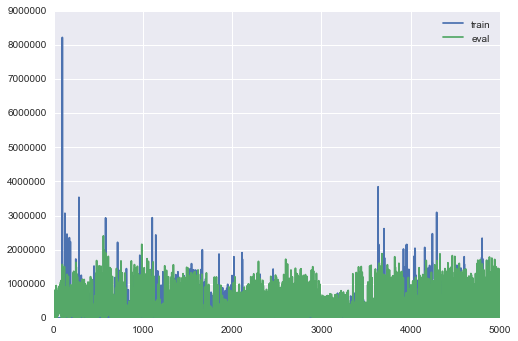

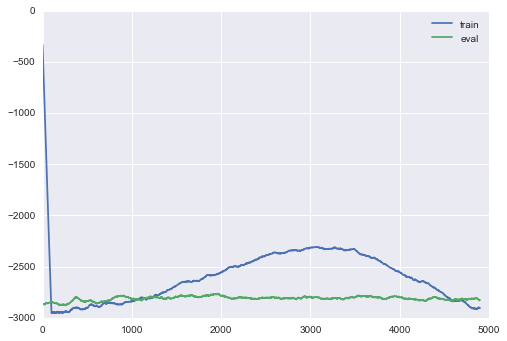

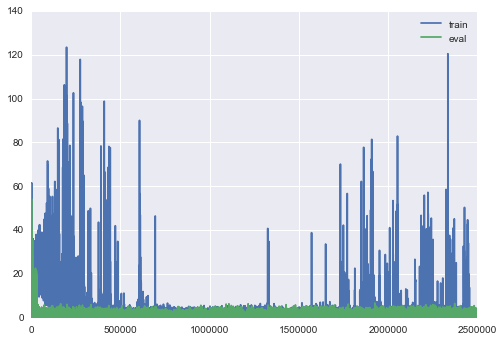

In [61]:
def plot_error(a, b):
    error = []
    for x,y in zip(a, b):
        error.append((x-y)**2)
    plt.plot(error)
#     plt.show()

plot_error(rewards_train, actual_episode_rewards_train)
plot_error(rewards_eval, actual_episode_rewards_eval)
plt.legend(['train','eval'])
plt.show()
plt.plot(smooth_graph(rewards_train))
plt.plot(smooth_graph(rewards_eval))
plt.legend(['train','eval'])
plt.show()
plt.plot(smooth_graph(td_error_train))
plt.plot(smooth_graph(td_error_eval))
plt.legend(['train','eval'])
plt.show()
# plt.plot(rewards_eval)
# plt.legend(['train','eval'])
# rewards_train_normal, td_error_train_normal = qlearning(False, 0.1, 1, 'SemisuperPendulumDecay-v0')
# rewards_eval_normal, td_error_eval_normal = qlearning(True, 0, 1, 'SemisuperPendulumDecay-v0')

In [ ]:
# plt.plot(smooth_graph(rewards_train))
# plt.plot(smooth_graph(rewards_eval))
td_error_train_norm = [x**2 for x in td_error_train]
td_error_eval_norm = [x**2 for x in td_error_eval]
plt.plot(smooth_graph(td_error_train_norm))
plt.plot(smooth_graph(td_error_eval_norm))
# plt.plot(smooth_graph(rewards_train_normal))
# plt.plot(smooth_graph(rewards_eval_normal))

In [ ]:
plt.plot(smooth_graph(rewards_train))
plt.plot(smooth_graph(rewards_eval))


# episode_rewards_train, td_error_train = qlearning(False, 0.1, 1)
# episode_rewards_eval, td_error_eval = qlearning(True, 0, 1)
# plt.plot(smooth_graph(episode_rewards_train))
# plt.plot(smooth_graph(episode_rewards_eval))

In [71]:
def save_pickle_dump(q_name, oc_name):
    pickle.dump(Q, open(q_name, "wb"))
    pickle.dump(Observed_Counts, open(oc_name, "wb"))
    
def load_pickle_dump(q_name, oc_name):
    observed_counts = pickle.load( open(q_name, "rb" ) )
    Q = pickle.load( open(oc_name, "rb" ) )
    return observed_counts, Q

def render(q, oc ,env_name):
    Q, _ = load_pickle_dump(q, oc)
    env = gym.make(env_name)
    S = env.reset()
    env.render()
    for t in range(NO_OF_ITER):
        dis_S = get_discrete_state(S)
        max_action = max(Q[dis_S], key=Q[dis_S].get)
        S, reward, _, _ = env.step([max_action])
        env.render()

def Q_value_analysis():
    pass

In [72]:
# environments = ['Pendulum-v0','SemisuperPendulumNoise-v0','SemisuperPendulumRandom-v0','SemisuperPendulumDecay-v0']
environments = ['SemisuperPendulumRandom-v0']
def plot_reward_environments(train, test, legend):
    all_legend = []
    for reward, l in zip(train,legend):
        plt.plot(smooth_graph(reward))
        all_legend.append(l+'_train')
    for reward, l in zip(test,legend):
        plt.plot(smooth_graph(reward))
        all_legend.append(l+'_eval')
    plt.ylabel('Total Reward')
    plt.xlabel('Episode Number')
    plt.legend(all_legend, loc='best')
    plt.show()
    
def test_environments():
#     environments = ['Pendulum-v0','SemisuperPendulumNoise-v0','SemisuperPendulumRandom-v0','SemisuperPendulumDecay-v0']
    environments = ['SemisuperPendulumRandom-v0']
    all_episodes_train, all_episodes_eval = [], []
    all_td_error_train, all_td_error_eval = [], []
    for env in environments:
        print 'Testing '+ env
        episode_rewards_train, td_error_train = qlearning(False, 0.2, 1, env)
        episode_rewards_eval, td_error_eval = qlearning(True, 0, 1, env)
        all_episodes_train.append(copy.deepcopy(episode_rewards_train))
        all_episodes_eval.append(copy.deepcopy(episode_rewards_eval))
        all_td_error_train.append(copy.deepcopy(td_error_train))
        all_td_error_eval.append(copy.deepcopy(td_error_eval))
        save_pickle_dump("Q" + filename + "_" + env + ".p", "ObservedCounts" + filename + '_' + env + ".p")
    plot_reward_environments(all_episodes_train, all_episodes_eval, environments)

[2016-11-25 09:39:09,696] Making new env: SemisuperPendulumRandom-v0


Testing SemisuperPendulumRandom-v0
Action Space
Box(1,)
Observation Space
Box(3,)
Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900


[2016-11-25 09:39:48,256] Making new env: SemisuperPendulumRandom-v0


Action Space
Box(1,)
Observation Space
Box(3,)
Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900


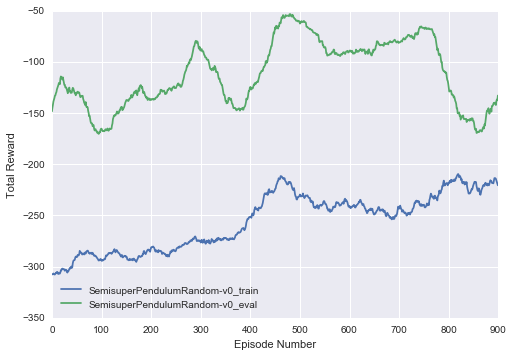

In [73]:
test_environments()
# environments = ['Pendulum-v0']

In [74]:
for env in environments:
    render("Q" + filename + "_" + env + ".p", "ObservedCounts" + filename + '_' + env + ".p", env)

[2016-11-25 09:43:30,655] Making new env: SemisuperPendulumRandom-v0


Action Space
Box(1,)
Observation Space
Box(3,)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_Q_values(Q):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    w = 360/ANGLE_TILE_SIZE
    h = len(thetadot_bin.keys())
    grid = [[0 for x in range(w)] for y in range(h)] 
    for theta in range(0, 360/ANGLE_TILE_SIZE):
        for thetadot in thetadot_bin.keys():
            state = (theta, thetadot)
            a = max(Q[state], key=Q[state].get)
            ax.scatter(theta, thetadot, a, zdir='z')
    plt.show()
Q, _ = load_pickle_dump("Q" + filename + "_" + env + ".p", "ObservedCounts" + filename + '_' + env + ".p")
# print Q
plot_Q_values(Q)
